In [87]:
# import the packages
import numpy as np
from scipy.fftpack import dct
from scipy.io import loadmat
from numpy.linalg import lstsq
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

In [95]:
# -----------------------------------------------------------
# Step 1: Preprocessing (normalize to [-1,1])
# -----------------------------------------------------------
def normalize_signal(x):
    xmax = np.max(x[x > 0]) if np.any(x > 0) else 1
    xmin = np.min(x[x < 0]) if np.any(x < 0) else -1
    x_norm = np.zeros_like(x, dtype=float)

    x_norm[x > 0] = x[x > 0] / xmax
    x_norm[x < 0] = x[x < 0] / abs(xmin)

    return x_norm

In [116]:
# -----------------------------------------------------------
# Step 2: Sparse Linear Prediction (simplified AR coeffs)
# -----------------------------------------------------------
def slp_coefficients(x, K=20, gamma_range=np.linspace(0.01, 1.5, 30)):
    """
    Sparse Linear Prediction with optimal gamma selection (Annex F.1.2).
    
    Args:
        x : 1D numpy array (input vibrotactile frame)
        K : int, prediction order
        gamma_range : array-like, values of gamma to try
    
    Returns:
        a_opt : numpy array, optimal SLP coefficients
        gamma_opt : float, selected gamma value
        coeff_norms : list of ||a||_1 values for each gamma
        residual_norms : list of ||x - Xa||_1 values for each gamma
    """
    N = len(x)
    # Construct regression matrix
    X = np.zeros((N-K, K))
    for i in range(K, N):
        X[i-K] = x[i-K:i][::-1]
    y = x[K:]

    

    # Initialize coefficients (x) to all zeros
    a = np.zeros(X.shape[1])

    residual_norms = []
    coeff_norms = []
    solutions = []

    # Sweep gamma values
    for gamma in gamma_range:

        n_samples, n_features = X.shape
    
        # Initialize coefficients 'a' with a small non-zero value to avoid division by zero
        a = np.random.rand(n_features) * 1e-6

        # Start the IRLS loop
        for i in range(100):
            # Store the previous coefficients for convergence check
            a_prev = a.copy()
        
            # --- Step 1: Calculate the weights for the data-fitting term ---
            # The weights are the inverse of the absolute values of the residuals.
            residuals = y - X @ a
            # Add a small epsilon to prevent division by zero
            w_data = 1.0 / (np.abs(residuals) + 1e-12)
            # Create a diagonal weight matrix for the data term
            W = np.diag(w_data)
        
            # --- Step 2: Calculate the weights for the regularization term ---
            # The weights are the inverse of the absolute values of the coefficients.
            # Add a small epsilon to prevent division by zero
            w_reg = 1.0 / (np.abs(a) + 1e-12)
            # Create a diagonal weight matrix for the regularization term
            W_reg = np.diag(w_reg)
        
            # --- Step 3: Solve the weighted least squares problem ---
            # This is the core update step of IRLS. The closed-form solution is:
            # a = (Y^T W^2 Y + gamma*W_reg)^-1 * Y^T W^2 y
        
            # Calculate the left-hand side of the normal equation
            lhs = X.T @ W @ W @ X + gamma * W_reg
            # Calculate the right-hand side of the normal equation
            rhs = X.T @ W @ W @ y
        
            try:
                # Solve the linear system
                a = np.linalg.solve(lhs, rhs)
            except np.linalg.LinAlgError:
                # Handle cases where the matrix is singular
                print("Singular matrix encountered, stopping.")
                break
            
            # --- Step 4: Check for convergence ---
            # If the change in coefficients is below the tolerance, we have converged.
            if np.linalg.norm(a - a_prev) < 1e-6:
                print(f"Converged after {i+1} iterations.")
                break
        else:
            print("Maximum iterations reached without convergence.")

        r = y - X @ a
        residual_norms.append(np.linalg.norm(r, 1))
        coeff_norms.append(np.linalg.norm(a, 1))
        solutions.append(a)

    residual_norms = np.array(residual_norms)
    coeff_norms = np.array(coeff_norms)

    # Find "corner" of the L-curve (max distance to line between endpoints)
    """x1, y1 = coeff_norms[0], residual_norms[0]
    x2, y2 = coeff_norms[-1], residual_norms[-1]
    distances = []
    for xi, yi in zip(coeff_norms, residual_norms):
        num = abs((y2-y1)*xi - (x2-x1)*yi + x2*y1 - y2*x1)
        den = np.sqrt((y2-y1)**2 + (x2-x1)**2)
        distances.append(num/den)
    best_idx = int(np.argmax(distances))

    gamma_opt = gamma_range[best_idx]
    a_opt = solutions[best_idx]
    x_tilde = X @ a_opt"""

    # Log-log scale for curvature calculation
    x_log = np.log(coeff_norms + 1e-12)   # avoid log(0)
    y_log = np.log(residual_norms + 1e-12)

    # Numerical derivatives w.r.t. gamma (parametric form)
    dx = np.gradient(x_log, np.log(gamma_range))
    dy = np.gradient(y_log, np.log(gamma_range))
    ddx = np.gradient(dx, np.log(gamma_range))
    ddy = np.gradient(dy, np.log(gamma_range))

    # Curvature formula κ = |x'y'' - y'x''| / ( (x'^2 + y'^2)^(3/2) )
    curvatures = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5

    # Pick gamma with maximum curvature
    best_idx = int(np.argmax(curvatures))
    gamma_opt = gamma_range[best_idx]
    a_opt = solutions[best_idx]
    x_tilde = X @ a_opt
    
    return a_opt, gamma_opt, coeff_norms, residual_norms, x_tilde

In [40]:
# -----------------------------------------------------------
# Step 3: SLP to RC (Levinson recursion simplified)
# -----------------------------------------------------------
def slp_to_rc(a):
    N = len(a)
    rc = np.zeros(N)
    a_curr = a.copy()
    for n in range(N, 0, -1):
        rc[n-1] = -a_curr[-1]
        if n > 1:
            a_prev = a_curr[:-1]
            a_curr = (a_prev + rc[n-1] * a_prev[::-1]) / (1 - rc[n-1]**2)
    return rc

In [41]:
# -----------------------------------------------------------
# Step 4: RC Quantization
# -----------------------------------------------------------
def quantize_rc(rc, delta=0.03):
    rc_q = np.round(rc / delta)
    rc_deq = rc_q * delta
    return rc_q, rc_deq

In [42]:
# -----------------------------------------------------------
# Step 5: RC to SLP Transformation (Levinson recursion)
# -----------------------------------------------------------
def rc_to_slp(rc):
    N = len(rc)
    slp = np.zeros((N, N))
    for m in range(N):
        slp[m, m] = 1
    a = np.zeros(N)
    for k in range(N):
        a[k] = rc[k]
        if k > 0:
            a[:k] += rc[k] * slp[k-1, :k][::-1]
        slp[k, :k+1] = a[:k+1]
    return a

In [43]:
# -----------------------------------------------------------
# Step 6: Residual Computation
# -----------------------------------------------------------
def compute_residual(x, a):
    K = len(a)
    N = len(x)
    r = np.zeros(N)
    for n in range(K, N):
        r[n] = x[n] + np.sum(a * x[n-K:n][::-1])
    return r

In [44]:
# -----------------------------------------------------------
# Step 7: Residual DCT + Perceptual Quantization
# -----------------------------------------------------------
def residual_dct_quant(r, asf, delta=0.1):
    R = dct(r, type=2, norm='ortho')
    eq = np.round(R / (delta * asf))
    eq_deq = eq * delta * asf
    return R, eq, eq_deq

In [45]:
# -----------------------------------------------------------
# Load Huffman dictionary from .mat file
# -----------------------------------------------------------
def load_huff_dict(mat_file, var_name):
    """Load Huffman dictionary from .mat file as a Python dict."""
    mat_data = loadmat(mat_file)
    entries = mat_data[var_name]   # cell array of shape (N, 2)
    
    huff_dict = {}
    for symbol, code in entries:
        sym = symbol.item()        # extract Python scalar
        huff_dict[sym] = str(code[0])  # extract string from MATLAB char array
    return huff_dict

In [46]:
def _detect_eob_symbol(huff_dict):
    """
    Heuristic: EOB often has a very short code (often length 1), or is a very large sentinel.
    1) Prefer any symbol with 1-bit code.
    2) Fallback to the largest integer symbol.
    """
    lengths = {s: len(c) for s, c in huff_dict.items()}
    one_bit = [s for s, L in lengths.items() if L == 1]
    if one_bit:
        return one_bit[0]
    # fallback: largest integer symbol
    ints = [s for s in huff_dict.keys() if isinstance(s, (int, np.integer))]
    return max(ints) if ints else None

In [91]:
# -----------------------------------------------------------
# Step 8: Zero Run Length Encoder
# -----------------------------------------------------------
def zrl_encode_flat(coeffs, dct_dict, eob_symbol=None):
    """
    Given a 1-D array/list of quantized DCT coeffs (ints), produce a FLAT sequence:
      - Nonzero v  -> emit v
      - Run of z 0s -> emit 0, z    (possibly split if z exceeds supported run values)
      - Append EOB at the end
    The run-lengths and nonzero values are both encoded as integers; context disambiguates them.
    """
    if eob_symbol is None:
        eob_symbol = _detect_eob_symbol(dct_dict)
        if eob_symbol is None:
            raise ValueError("Could not detect EOB symbol from the dictionary. Please pass eob_symbol explicitly.")

    # Allowed integer symbols we can emit for a run length (positive ints except 0 and EOB)
    allowed_runs = sorted(int(s) for s in dct_dict.keys()
                          if isinstance(s, (int, np.integer)) and s not in (0, eob_symbol) and s >= 1)

    out = []
    run = 0
    for v in coeffs:
        v = int(v)
        if v == 0:
            run += 1
            continue

        # flush any pending zeros as 0,chunk pairs
        if run > 0:
            while run > 0:
                # choose largest allowed chunk <= run (fallback 1 if needed)
                chunk = max([r for r in allowed_runs if r <= run] or [1])
                out.extend([0, chunk])
                run -= chunk

        # emit the non-zero coefficient as-is
        out.append(v)

    # tail zeros
    if run > 0:
        while run > 0:
            chunk = max([r for r in allowed_runs if r <= run] or [1])
            out.extend([0, chunk])
            run -= chunk

    # end-of-block
    out.append(eob_symbol)
    return out

In [48]:
# -----------------------------------------------------------
# Step 9: Huffman Encoder
# -----------------------------------------------------------
def huffman_encode(sequence, huff_dict):
    """
    Encode a sequence of symbols using a Huffman dictionary.
    sequence: iterable of symbols
    huff_dict: {symbol: code}
    Returns a string of concatenated Huffman bits.
    """
    encoded_bits = ""
    for symbol in sequence:
        if symbol not in huff_dict:
            raise ValueError(f"Symbol {symbol} not in Huffman dictionary")
        encoded_bits += huff_dict[symbol]
    return encoded_bits

In [49]:
def huffman_encode_sequence(symbols, huff_dict):
    """
    Encode a flat sequence of integers using the provided {symbol: bitstring} dict.
    Returns one concatenated bitstring.
    """
    missing = []
    bits = []
    for s in symbols:
        if s not in huff_dict:
            missing.append(s)
        else:
            bits.append(huff_dict[s])
    if missing:
        raise KeyError(f"Symbols not present in Huffman dict (first 10): {missing[:10]}")
    return ''.join(bits)

In [117]:
# -----------------------------------------------------------
# Example Run
# -----------------------------------------------------------
if __name__ == "__main__":

    tooltip = "1spike_Probe" # 1spike_Probe, 3x1small-round_Probe, 3x1spike_Probe, 3x3_Probe, 3x3small-round_Probe, big-half-round_Probe, big-round_Probe, finger_Probe
    material = "rubber"  # BalticBrown, aluminiumGrid, antiVibPad, bamboo, cork, felt, foam, polyesterPad, rubber
    speed = "fast"  # medium, fast
    sampling_rate = 2800
    dct_quantization_scale = 1.0
    num_samples_per_frame = 200
    ar_order = 40

    acc_samples_filename = "./signal_trace_data/Direct_-_" + tooltip + "_-_" + material + "_-_" + speed + ".mat"

    rc_dict  = load_huff_dict("HuffmanDicRC.mat", "dict_RC")
    dct_dict = load_huff_dict("HuffmanDicDCT_QDCT_22.mat", "dict_DCT")

    data = loadmat(acc_samples_filename)
    material_samples = data["material"]

    acc_combined_cut_frame = material_samples["joinedAccPaperCut"][0,0]
    acc_combined_cut_frame = np.asarray(acc_combined_cut_frame).flatten()

    # Step 1: Normalize
    x_norm = normalize_signal(acc_combined_cut_frame)

    # Step 2: SLP coefficients
    a_opt, gamma_opt, residual_norms, coeff_norms, x_tilde = slp_coefficients(x_norm, K=ar_order)

    # Step 3: RC
    #rc = slp_to_rc(a_opt)

    # Step 4: Quantize RCs
    #rc_q, rc_deq = quantize_rc(rc)

    # Step 5 (corrected): Convert dequantized RC back to SLP
    #a_deq = rc_to_slp(rc_deq)

    # Step 6: Residual
    #r = compute_residual(x_norm, a_deq)

    # Step 7: Residual DCT + Perceptual Quantization
    #asf = np.ones_like(r)  # placeholder ASF = 1
    #R, eq, eq_deq = residual_dct_quant(r, asf, dct_quantization_scale)

    # Step 8: Zero Run Length Encode residuals
    #zrl_seq = zrl_encode_flat(eq, dct_dict)  # produces [v, 0, run, v, ..., EOB]

    # Step 9: Huffman Encode
    #rc_bits  = huffman_encode(rc_q, rc_dict)
    #res_bits = huffman_encode_sequence(zrl_seq, dct_dict)

    # Print key variables
    print("Normalized x:", x_norm[:10])
    print("SLP coeffs:", a_opt[:5])
    #print("RCs:", rc[:5])
    #print("Quantized RCs:", rc_q[:5])
    #print("Residual:", r[:10])
    #print("DCT coeffs:", R[:10])
    #print("Quantized DCT:", eq[:10])
    #print("ZRL residuals:", zrl_res[:10])
    #print("Huffman encoded RC bits:", rc_bits[:50], "...")
    #print("Huffman encoded Residual bits:", res_bits[:50], "...")

Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without convergence.
Maximum iterations reached without conve

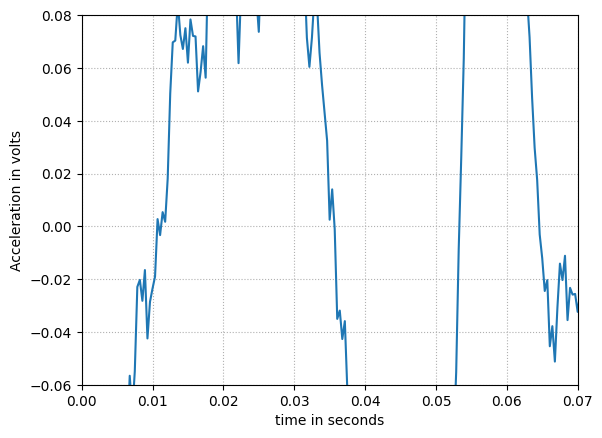

In [55]:
# -----------------------------------------------------
# Printing the time series of the combined acceleration
# ----------------------------------------------------- 

plt.plot(np.arange(0,num_samples_per_frame) / sampling_rate, acc_combined_cut_frame)
plt.xlabel("time in seconds")
plt.ylabel("Acceleration in volts")
plt.xlim(0,0.07)
plt.ylim(-0.06,0.08)
plt.grid(True, linestyle=':')


<StemContainer object of 3 artists>

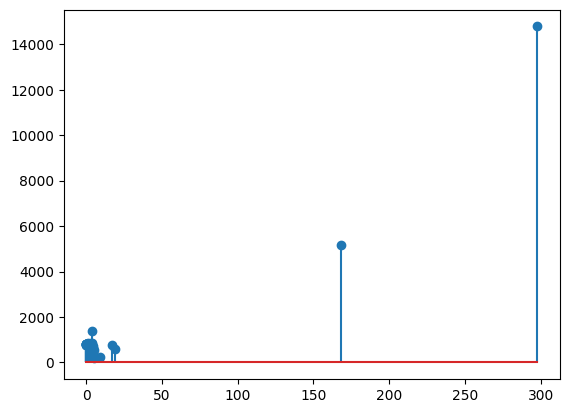

In [118]:
# -------------------------------------
# Print the SLP prediction coefficients
# -------------------------------------

#plt.stem(a_opt)
plt.stem(residual_norms, coeff_norms)

In [73]:
print(a_opt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(4097,)
(4097,)


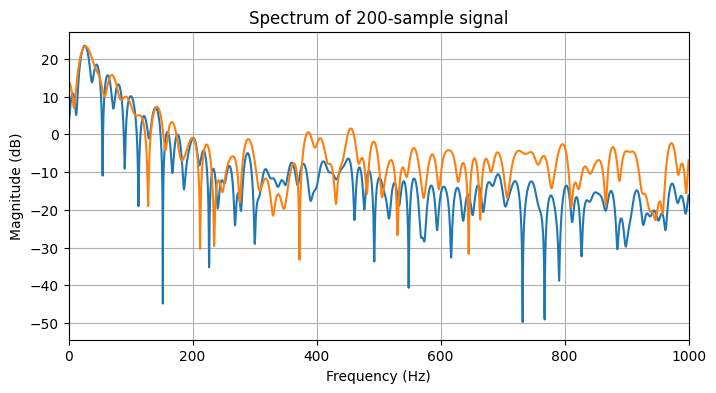

In [ ]:
import matplotlib.pyplot as plt

nfft = 8192
fs = 2800
acc_combined_cut_frame_rfft = np.fft.rfft(acc_combined_cut_frame, n=nfft)
freqs = np.fft.rfftfreq(nfft, 1/fs)

mag_db = 20 * np.log10(np.abs(acc_combined_cut_frame_rfft) + 1e-12)

x_tilde_rfft = np.fft.rfft(x_tilde, n=nfft)  
#R = np.fft.rfft(r)         # FFT
#R_db = 20*np.log10(np.abs(R)+1e-12)
x_tilde_rfft_db = 20*np.log10(np.abs(x_tilde_rfft)+1e-12)

#haha = 20 * np.log10(np.abs(acc_combined_cut_fft) + 1e-12)

print(acc_combined_cut_frame_rfft.shape)
print(x_tilde_rfft_db.shape)

plt.figure(figsize=(8,4))
plt.plot(freqs, mag_db)
plt.plot(freqs, x_tilde_rfft_db)
plt.xlim(0, 1000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Spectrum of 200-sample signal")
plt.grid(True)
plt.show()

In [ ]:
print(encoded_data['slp_coeffs'])


[array([ 0.81750588,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ])]
